In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.metrics import cdist_dtw, dtw
from scipy.signal import correlate

/tmp/ipykernel_119219/1785983841.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/giovani/anaconda3/envs/wavelet_code/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# (n, t, k)

# (t, k)

In [28]:
def save_dtw_dist_matrix(poly_division, time_interval):
    # load and normalize signals

    df = pd.read_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv")
    features = df.columns[2:]
    signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
    for i in range(signal_multi.shape[2]):
        mu = np.mean(signal_multi[:, :, i])
        sigma = np.std(signal_multi[:, :, i])

        if sigma == 0:
            sigma = 1
        signal_multi[:, :, i] = (signal_multi[:, :, i] - mu) / sigma

    # calculate dtw distance matrix
    geral_dist = np.zeros((signal_multi.shape[2], signal_multi.shape[2]))
    for i in tqdm(range(signal_multi.shape[0])):
        sample_dist = dtw_similarity(signal_multi[i], r = 5)
        geral_dist += sample_dist   

    geral_dist /= signal_multi.shape[0] 

    df = []
    for i in range(geral_dist.shape[0]):
        for j in range(i, geral_dist.shape[1]):
            df.append({
                "row": features[i],
                "column": features[j],
                "value": geral_dist[i, j]
            })
    df = pd.DataFrame(df)

    df.to_csv(f"data/similarity_matrix/{poly_division}_{time_interval}.csv", index=False)

In [29]:
for time_interval in ["Month", "Day"]:
    for poly_division in ["SpGrid", "SpDistricts", "SpCenterCensus5k"]:
        save_dtw_dist_matrix(poly_division, time_interval)

/tmp/ipykernel_119219/3312879201.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
100%|██████████| 4900/4900 [00:12<00:00, 385.56it/s]
/tmp/ipykernel_119219/3312879201.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_multi = np.stack(df.groupby("id_poly").apply(l

In [ ]:
poly_division = "SpCenterCensus5k"
time_interval = "Month"

In [4]:
df = pd.read_csv(f"data/polygon_data/{poly_division}_{time_interval}.csv")
features = df.columns[2:]
signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)
for i in range(signal_multi.shape[2]):
    mu = np.mean(signal_multi[:, :, i])
    sigma = np.std(signal_multi[:, :, i])

    if sigma == 0:
        sigma = 1
    signal_multi[:, :, i] = (signal_multi[:, :, i] - mu) / sigma

    

/tmp/ipykernel_119219/3919161764.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signal_multi = np.stack(df.groupby("id_poly").apply(lambda x: x.sort_values("date").drop(columns=["id_poly", "date"]).values).values)


In [26]:
def euclidean_similarity(multi_ts):
    assert multi_ts.ndim == 2
    k = multi_ts.shape[1]
    out = np.zeros((k, k))
    for i in range(k):
        for j in range(i, k):
            d = ((multi_ts[:, i] - multi_ts[:, j])**2).sum()
            out[i, j] = 1 if d == 0 else 1 / d
            out[j, i] = out[i, j]	
    return out

def time_series_corr(multi_ts):
    assert multi_ts.ndim == 2
    return np.abs(np.corrcoef(multi_ts, rowvar=False))

def dtw_similarity(multi_ts, r = 1):
    assert multi_ts.ndim == 2
    k = multi_ts.shape[1]
    out = np.zeros((k, k))
    for i in range(k):
        for j in range(i, k):
            d = dtw(multi_ts[:, i], multi_ts[:, j], global_constraint="sakoe_chiba", sakoe_chiba_radius=r)
            out[i, j] = d
            out[j, i] = out[i, j]	
    return out

def cross_correlation_similarity(multi_ts):
    assert multi_ts.ndim == 2
    k = multi_ts.shape[1]
    out = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            out[i, j] = correlate(multi_ts[:, i], multi_ts[:, j]).max()
    return out

In [7]:
mean_signal = np.mean(signal_multi, axis=0)[:, :7]

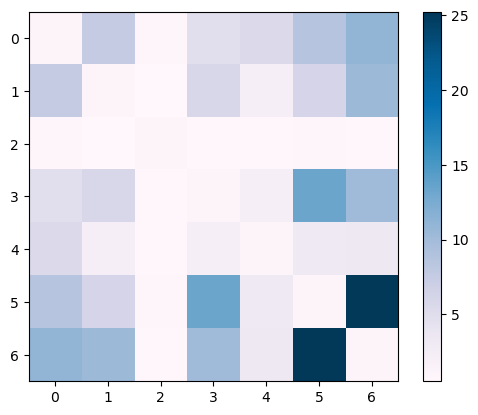

In [61]:
plt.imshow(euclidean_similarity(mean_signal), cmap = "PuBu")
plt.colorbar()

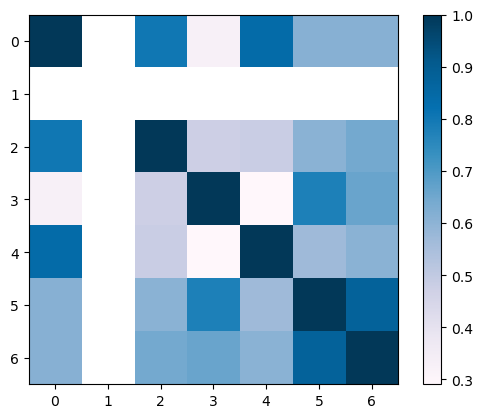

In [62]:
plt.imshow(time_series_corr(mean_signal), cmap = "PuBu")
plt.colorbar()

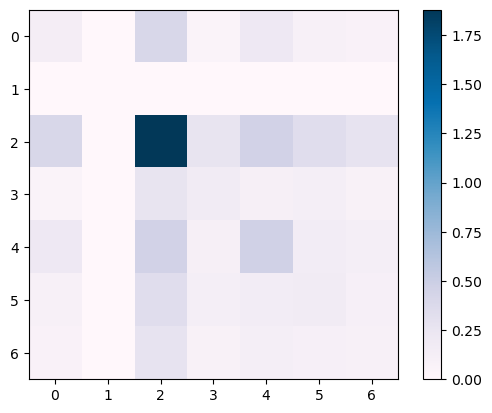

In [63]:
plt.imshow(cross_correlation_similarity(mean_signal), cmap = "PuBu")
plt.colorbar()

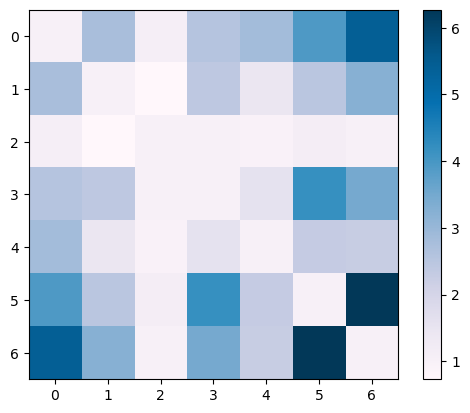

In [64]:
plt.imshow(dtw_similarity(mean_signal), cmap = "PuBu")
plt.colorbar()

In [13]:
from tqdm import tqdm

In [14]:
geral_dist = np.zeros((signal_multi.shape[2], signal_multi.shape[2]))
for i in tqdm(range(signal_multi.shape[0])):
    sample_dist = dtw_similarity(signal_multi[i])
    geral_dist += sample_dist

100%|██████████| 5000/5000 [00:13<00:00, 372.24it/s]


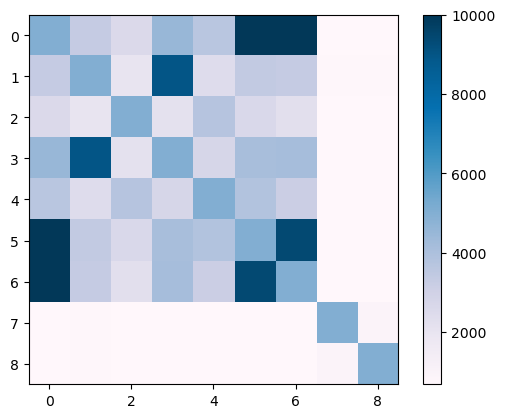

In [20]:
plt.imshow(geral_dist, cmap = "PuBu", vmax = 10000)
plt.colorbar()

In [21]:
# convert geral_dist to dataframe

df = []
for i in range(geral_dist.shape[0]):
    for j in range(i, geral_dist.shape[1]):
        df.append({
            "row": features[i],
            "column": features[j],
            "value": geral_dist[i, j]
        })
df = pd.DataFrame(df)

In [22]:
df

,row,column,value
0,Accident,Accident,5000.000000
1,Accident,Hazard,3307.126310
2,Accident,Jam,2547.684252
3,Accident,Road Closed,4491.314945
4,Accident,Weather Hazard,3645.585997
5,Accident,Phone Theft,10476.894049
6,Accident,Phone Robbery,111361.801105
7,Accident,Temperature,689.600727
8,Accident,Precipitation,692.370532
9,Hazard,Hazard,5000.000000
